In [31]:
# Python Image Library is a very useful library for processing images
from keras.models import Sequential, Model
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras import layers
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import cv2 
import os
import fnmatch
from sklearn import svm
from sklearn.metrics import accuracy_score
from tensorflow import keras
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [32]:
train_path = "Demo_dataset"
train_chinese = os.listdir(train_path)
df_train = pd.DataFrame(columns=["character", "filename", "label"])
len(train_chinese)

8

In [33]:
k = 0
for i in range(0, len(train_chinese)):
    if i != ".DS_Store":
        l = os.listdir(train_path + '/' + train_chinese[i])
        l = fnmatch.filter(l, '*.png')
        if len(l) > 200:
            l = l[:200]
        label = [k] * len(l)
        temp = pd.DataFrame({
            "character": train_chinese[i],
            "filename": l,
            "label": label
        })
        #print(temp)
        df_train = pd.concat([df_train, temp])      
    k += 1

In [34]:
df_train

,character,filename,label
0,理,176.png,0
1,理,88.png,0
2,理,162.png,0
3,理,189.png,0
4,理,77.png,0
...,...,...,...
195,鸫,93.png,7
196,鸫,78.png,7
197,鸫,186.png,7
198,鸫,192.png,7


In [35]:
train_array = np.zeros((df_train.shape[0], 128, 128, 3))
for i in range(df_train.shape[0]):
    if df_train.iloc[i]['filename'] != ".DS_Store":
        image_path = train_path + '/' + df_train.iloc[i]['character'] + '/' + df_train.iloc[i]['filename']
        # get grayscale image
        # print(image_path)
        image = cv2.imread(image_path)
        # remove noise
        out = cv2.medianBlur(image, 5)
        # normalize the image
        resultimage = np.zeros(out.shape)
        normalizedimage = cv2.normalize(out, resultimage, 0, 255, cv2.NORM_MINMAX)
        # resize the image 
        resizeimage = cv2.resize(normalizedimage, (128,128))

        blue, green, red = cv2.split(resizeimage) 
        # apply principal component analysis
        pca = PCA(50)
        red_transformed = pca.fit_transform(red)
        red_inverted = pca.inverse_transform(red_transformed)

        #Applying to Green channel and then applying inverse transform to transformed array.
        green_transformed = pca.fit_transform(green)
        green_inverted = pca.inverse_transform(green_transformed)

        #Applying to Blue channel and then applying inverse transform to transformed array.
        blue_transformed = pca.fit_transform(blue)
        blue_inverted = pca.inverse_transform(blue_transformed)

        img_compressed = (np.dstack((red_inverted, red_inverted, red_inverted))).astype(np.uint8)
        train_array[i] = img_compressed



In [36]:
train_array = train_array / 255

In [37]:
y = df_train["label"].to_numpy()

In [38]:
y = y.astype('int')

In [39]:
input_array = np.transpose(train_array, (0, 3, 1, 2))

In [40]:
input_array.shape

(1600, 3, 128, 128)

In [41]:
len(np.unique(y))

8

In [46]:
model = keras.models.Sequential([

    keras.layers.Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),

    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8,activation='softmax')
    
    ])

In [47]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']    
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 30, 30, 64)        23296     
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 128)       204928    
_________________________________________________________________
batch_normalization_14 (Batc (None, 15, 15, 128)       512       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 5, 5, 128)        

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_array,y)

In [49]:
history=model.fit(
    X_train, y_train,
    epochs = 20,
    validation_data = (X_test, y_test),
    validation_freq = 1
)


Epoch 1/20
38/38 [==============================] - 6s 157ms/step - loss: 2.7478 - accuracy: 0.1725 - val_loss: 2.0821 - val_accuracy: 0.1325
Epoch 2/20
38/38 [==============================] - 6s 153ms/step - loss: 2.3229 - accuracy: 0.2125 - val_loss: 2.0851 - val_accuracy: 0.1325
Epoch 3/20
38/38 [==============================] - 6s 155ms/step - loss: 2.1182 - accuracy: 0.2892 - val_loss: 2.0965 - val_accuracy: 0.1325
Epoch 4/20
38/38 [==============================] - 6s 161ms/step - loss: 1.9296 - accuracy: 0.3067 - val_loss: 2.1183 - val_accuracy: 0.1325
Epoch 5/20
38/38 [==============================] - 6s 171ms/step - loss: 1.6677 - accuracy: 0.4092 - val_loss: 2.1208 - val_accuracy: 0.1375
Epoch 6/20
38/38 [==============================] - 8s 210ms/step - loss: 1.5455 - accuracy: 0.4483 - val_loss: 2.0735 - val_accuracy: 0.1425
Epoch 7/20
38/38 [==============================] - 7s 182ms/step - loss: 1.4624 - accuracy: 0.4833 - val_loss: 1.9826 - val_accuracy: 0.2025
Epoch 

<Figure size 720x720 with 0 Axes>

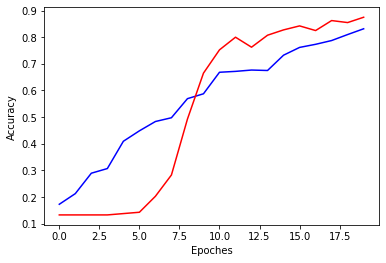

<Figure size 720x720 with 0 Axes>

In [50]:

plt.plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
plt.plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.figure(figsize = (10, 10))


In [51]:
np.max(history.history['val_accuracy'])

0.875